In [1]:
import numpy as np
import pandas as pd
import soundfile as sf
import ffmpeg
import matplotlib.pyplot as plt
import time
from pyannote.audio import Pipeline
import torch
from os import listdir
from os.path import isfile, join
import pickle
from itertools import combinations
import sklearn
from sklearn.neighbors import KernelDensity
import pickle
import scipy
import seaborn as sns
from PyannoteUtility import Pydia, Confidence, Analyzer
import PyannoteUtility
import networkx as nx
import community as community_louvain
from scipy import stats

In [2]:
def measure_symmetry(M):
    # Compute the symmetric and antisymmetric parts
    S = (M + M.T) / 2
    A = (M - M.T) / 2

    # Compute the Frobenius norms
    norm_M = np.linalg.norm(M, 'fro')
    norm_S = np.linalg.norm(S, 'fro')
    
    # Avoid division by zero for the zero matrix
    if norm_M == 0:
        symmetry = 1.0  # or define as you wish when M is zero
    else:
        symmetry = norm_S / norm_M
    return symmetry

In [51]:
folder_path = "intervals_raw_data/MBC3/"
intro_end_list = [414,545,355,351,330,693,294,1667,800,547]
facillitator_list = [[3], [1], [2,3], [5,0], [2], [0,2], [3,6], [6,2], [0,2], [0]]

file_list = [f for f in listdir(folder_path) if f.startswith("MBC3") and f.endswith(".csv")]
file_list.sort()
dfs = []

for i,file_name in enumerate(file_list):
    file_path = join(folder_path, file_name)
    df = pd.read_csv(file_path)
    df = df[df['start']>intro_end_list[i]]
    dfs.append(df)

In [5]:
folder_path = "intervals_raw_data/MBC2/"
intro_end_list = [916,396,969,707,651,676,515,536,498]
facillitator_list = [[1],[0],[0],[0],[1],[0],[1],[0],[0]]

file_list = [f for f in listdir(folder_path) if f.startswith("MBC2") and f.endswith(".csv")]
file_list.sort()
dfs = []

for i,file_name in enumerate(file_list):
    file_path = join(folder_path, file_name)
    df = pd.read_csv(file_path)
    df = df[df['start']>intro_end_list[i]]
    dfs.append(df)

In [6]:
file_list

['MBC2_1-3_intervals.csv',
 'MBC2_2-1_intervals.csv',
 'MBC2_3-1_intervals.csv',
 'MBC2_3-2_intervals.csv',
 'MBC2_4-2_intervals.csv',
 'MBC2_4-3_intervals.csv',
 'MBC2_5-1_intervals.csv',
 'MBC2_5-2_intervals.csv',
 'MBC2_5-3_intervals.csv']

In [7]:
#Get Valid Speaker attend both MBC2 and MBC3
session_index = [0,2,4,6,7,8,9,10,11,14]

dfs = []

# Define a function to match total speaking time
def add_time(order):
    try:
        return df_list[i].loc[order]["total_time"]
    except:
        return None

def add_turn(order):
    try:
        return df_list[i].loc[order]["total_turns"]
    except:
        return None

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    dfs.append(df)

valid_speaker = []
for i in range(len(dfs)):
    tmpdf = dfs[i]
    tmp = tmpdf[tmpdf["First Name"].isin(MBC2_turns["First Name"])]["Order"].dropna().astype('int').tolist()
    tmp_result = pd.merge(tmpdf, MBC2_turns, on="First Name", how="left")
    tmp_result["Index"] = tmp_result.index
    valid_speaker.append(tmp_result[['Name', 'Turns', 'Order','Index']].dropna())

In [9]:
valid_speaker[3]['Order'] = [8,3,1,6,9]

In [10]:
valid_speaker[3]

,Name,Turns,Order,Index
2,Kate Hong,4,8,2
3,Marcelo Mattar,11,3,3
4,Megan Peters,12,1,4
5,Howard Gritton,6,6,5
6,Elizabeth McNeill,1,9,6


In [11]:
valid_speaker[7]['Order'] = [9,5,8,0]

In [11]:
pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[7])

,First Name,Last Name,Order
0,William,Gilpin,10.0
1,Antonio,Fernandez-Ruiz,3.0
2,Masashi,Tabuchi,11.0
3,Wilma,Bainbridge,NaN
4,Brian,Odegaard,4.0
5,Michael,Economo,5.0
6,Jean-Paul,Noel,9.0
7,Elizabeth,McNeill,8.0
8,Marcelo,Mattar,0.0
9,Robert,Wilson,1.0


In [ ]:
def combine_turn(df):
    df2 = pd.DataFrame({
    'duration': df['end_time'] - df['start_time'],
    'speaker_id': df['speaker_id']})
    # Step 2: Collapse consecutive identical IDs
    # Create a group identifier that increments when the ID changes
    group = (df2['id'] != df2['id'].shift()).cumsum()

    # Group by that identifier and sum durations while keeping the first ID
    result = df2.groupby(group).agg({'duration': 'sum', 'id': 'first'}).reset_index(drop=True)
    return result


In [7]:
def turn_switch(df, thres=0.4):
    cleaned_df = df[df['confidence']>thres].reset_index(drop=True)
    cleaned_df['prev_speaker_id'] = cleaned_df['speaker_id'].shift(1)
    transition_df = cleaned_df[cleaned_df['speaker_id']!=cleaned_df['prev_speaker_id']].reset_index(drop=True)
    transition_df = transition_df.dropna().reset_index(drop=True)
    transition_df['prev_speaker_id'] = transition_df['prev_speaker_id'].astype(int)
    return transition_df

In [8]:
def transition_matrix(df):
    first_column = 'speaker_id'
    second_column = 'prev_speaker_id'
    states = df[first_column].unique()
    states.sort()
    transition_matrix_turn = pd.DataFrame(0, index=states, columns=states, dtype=float)
    transition_matrix_time = pd.DataFrame(0, index=states, columns=states, dtype=float)
    for i in range(len(df)):
        current_state = df[first_column].iloc[i]
        next_state = df[second_column].iloc[i]
        transition_matrix_turn.loc[current_state, next_state] += 1
        transition_matrix_time.loc[current_state, next_state] += df.iloc[i]['end'] - df.iloc[i]['start']
    return transition_matrix_time, transition_matrix_turn

In [70]:
trans_matrix_turn_list = []
trans_matrix_time_list = []
transition_df_list = []
for i in range(len(dfs)):
    transition_df = turn_switch(dfs[i])
    trans_matrix_time, trans_matrix_turn = transition_matrix(transition_df)
    trans_matrix_turn_list.append(trans_matrix_turn)
    trans_matrix_time_list.append(trans_matrix_time)
    transition_df_list.append(transition_df)

In [66]:
sum(trans_matrix_time_list[0].sum())

1218.2000000000016

In [65]:
sum(trans_matrix_time_list[1].sum())

1835.559999999997

In [72]:
#Note when match with name, we exclude facilitators
session_index = [0,2,4,6,7,8,9,10,11,14]
trans_matrix_turn_list = []
trans_matrix_time_list = []

name_dfs = []
name_dicts = []

for i in range(len(session_index)):
    session_id = session_index[i]
    df = pd.read_excel("NameMatch/MBC3_Name_Match_noreindex.xlsx", sheet_name=session_index[i])
    #df = pd.read_excel("NameMatch/AUT1_Name_Match.xlsx", sheet_name=session_index[i])
    #add speaking time information to df
    df['Name'] = df['First Name'] + ' ' + df['Last Name']
    name_dict = df.set_index('Order')['Name'].to_dict()
    name_dfs.append(df)
    name_dicts.append(name_dict)

combined_df = pd.concat(name_dfs, ignore_index=True)

states = combined_df['Name'].unique()
total_transition_matrix_turn = pd.DataFrame(0, index=states, columns=states, dtype=float)
total_transition_matrix_time = pd.DataFrame(0, index=states, columns=states, dtype=float)

first_column = 'speaker_id'
second_column = 'prev_speaker_id'

for i in range(len(dfs)):
    transition_df = turn_switch(dfs[i])
    name_dict = name_dicts[i]
    
    tmp_states = name_dfs[i]['Name'].unique()
    tmp_transition_matrix_turn = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
    tmp_transition_matrix_time = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
    
    for j in range(len(transition_df)):
        current_state = transition_df[first_column].iloc[j] #'order'
        next_state = transition_df[second_column].iloc[j] #'order'
        if current_state in name_dict and next_state in name_dict:
            current_state = name_dict[current_state] #convert to 'name'
            next_state = name_dict[next_state] #convert to 'name'
        
            tmp_transition_matrix_turn.loc[current_state, next_state] += 1 #in transition matrix, the state is 'name'
            tmp_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['end'] - transition_df.iloc[j]['start']
            total_transition_matrix_turn.loc[current_state, next_state] += 1
            total_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['end'] - transition_df.iloc[j]['start']
    
    trans_matrix_turn_list.append(tmp_transition_matrix_turn)
    trans_matrix_time_list.append(tmp_transition_matrix_time)
            
            
            
        

In [69]:
sum(trans_matrix_time_list[1].sum())

608.9099999999997

## Real Data

### Turns

In [18]:
### Not use for now
# data_list store the turn-switch distribution of data
# result_array is the average of turn-switch distribution over all session
N = 8
result_array = np.zeros((N,N))
data_list = []
for i in range(len(trans_matrix_turn_list)):
    tmp = trans_matrix_turn_list[i].to_numpy()
    tmp = np.delete(tmp, facillitator_list[i], axis=0)  # Delete rows
    tmp = np.delete(tmp, facillitator_list[i], axis=1)  # Delete columns
    row_sums = np.sum(tmp, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    data_list.append(sorted_array[:N, :N]/np.sum(sorted_array[:N, :N]))
    #data_list.append(sorted_array/np.sum(sorted_array))
    result_array += sorted_array[:N, :N]
result_array = result_array/len(trans_matrix_turn_list)
#result_array = result_array/np.max(result_array)
#result_array[:,-1] = 0
result_array = result_array/np.sum(result_array)

In [18]:
data_list = []
for i in range(len(trans_matrix_turn_list)):
    tmp = trans_matrix_turn_list[i].to_numpy()
    rows = valid_speaker[i]['Order'].astype('int').to_list()
    columns = rows
    tmp = tmp[np.ix_(rows, columns)]
    row_sums = np.sum(tmp, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    data_list.append(sorted_array/np.sum(sorted_array))
    

In [115]:
data_list[0]

array([[0.        , 0.06976744, 0.05813953, 0.04651163, 0.03488372,
        0.04651163, 0.01162791, 0.02325581, 0.02325581],
       [0.09302326, 0.        , 0.        , 0.        , 0.        ,
        0.01162791, 0.01162791, 0.        , 0.        ],
       [0.02325581, 0.01162791, 0.        , 0.03488372, 0.03488372,
        0.01162791, 0.        , 0.        , 0.        ],
       [0.02325581, 0.01162791, 0.02325581, 0.        , 0.01162791,
        0.02325581, 0.01162791, 0.        , 0.01162791],
       [0.03488372, 0.        , 0.03488372, 0.01162791, 0.        ,
        0.01162791, 0.01162791, 0.        , 0.        ],
       [0.03488372, 0.        , 0.01162791, 0.03488372, 0.01162791,
        0.        , 0.        , 0.01162791, 0.        ],
       [0.02325581, 0.01162791, 0.        , 0.01162791, 0.01162791,
        0.01162791, 0.        , 0.        , 0.        ],
       [0.01162791, 0.        , 0.        , 0.01162791, 0.01162791,
        0.        , 0.        , 0.        , 0.        ],


In [118]:
import os
for idx, array in enumerate(data_list):
    file_path = os.path.join('Data/data_turn_switch', f"{session_index[idx]}.csv")
    np.savetxt(file_path, array, delimiter=",", fmt="%.5f")  # Use "%d" for integers or "%.2f" for floats

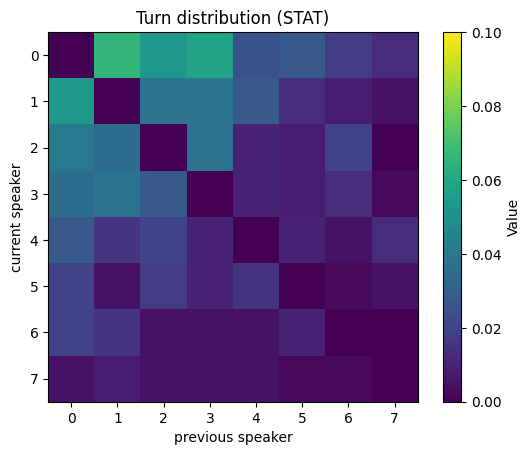

In [19]:
plt.imshow(result_array, cmap='viridis', vmin=0, vmax=0.1)
plt.colorbar(label='Value')  # Add a color bar to show the scale
plt.title('Turn distribution (STAT)')
plt.xlabel('previous speaker')
plt.ylabel('current speaker')
plt.show()

In [26]:
measure_symmetry(data_list[4])

0.9405399431259603

### Time

In [50]:
#Facilitator already removed
N = 8
result_array = np.zeros((N,N))
data_list = []
for i in range(len(trans_matrix_time_list)):
    tmp = trans_matrix_time_list[i].to_numpy()
    #tmp = np.delete(tmp, facillitator_list[i], axis=0)  # Delete rows
    #tmp = np.delete(tmp, facillitator_list[i], axis=1)  # Delete columns
    row_sums = np.sum(tmp, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    data_list.append(sorted_array[:N, :N]/np.sum(sorted_array[:N, :N]))
    #data_list.append(sorted_array/np.sum(sorted_array))
    result_array += sorted_array[:N, :N]
result_array = result_array/len(trans_matrix_time_list)
#result_array = result_array/np.max(result_array)
#result_array[:,-1] = 0
result_array = result_array/np.sum(result_array)

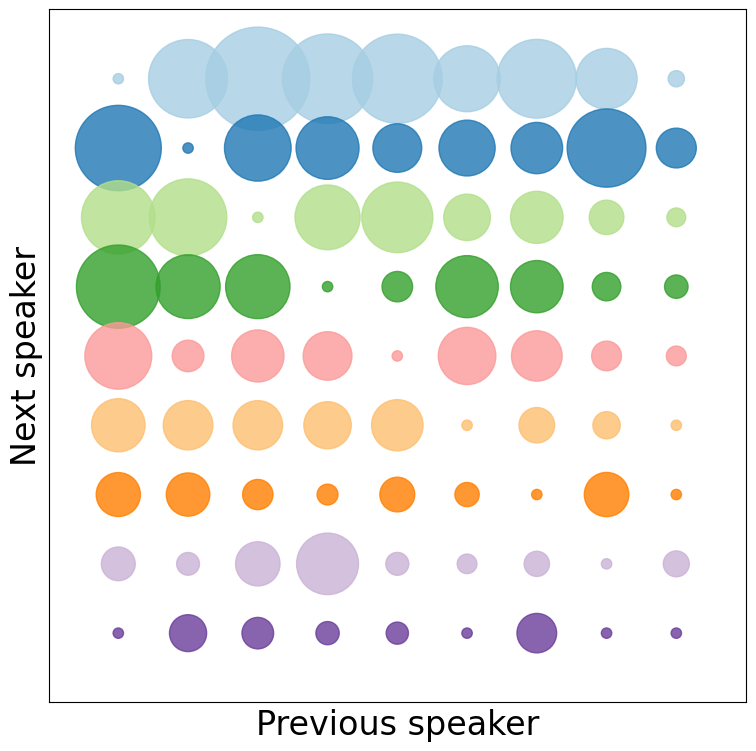

In [31]:
import matplotlib.patches as patches

cmap = plt.cm.get_cmap('Paired', 11)
colors = cmap(range(11))

# Generate a random 8x8 matrix for demonstration
np.random.seed(42)
N = 8
matrix = result_array

# Define row and column colors (using distinct colormap categories)
#row_colors = plt.cm.tab10(np.linspace(0, 1, N))  # 8 distinct row colors
#col_colors = plt.cm.Set2(np.linspace(0, 1, N))  # 8 distinct column colors
row_colors = colors[:9]
col_colors = colors[:9]

fig, ax = plt.subplots(figsize=(N, N))
ax.set_xlim(-1, N)
ax.set_ylim(-1, N)
ax.set_xticks(range(N))
ax.set_yticks(range(N))
ax.set_xticklabels(range(1, N+1))
ax.set_yticklabels(range(1, N+1))
ax.grid(True, linestyle="--", alpha=0.5)

# Normalize matrix values for dot size
min_size, max_size = 5, 500  # Size scaling for dots
sizes = min_size + (matrix - matrix.min()) / (matrix.max() - matrix.min()) * (max_size - min_size)

for i in range(N):
    for j in range(N):
        size = sizes[i, j]
        x, y = j, N-1 - i  # Flip y-axis for correct orientation
        
        # Get colors for the row and column
        row_color = row_colors[i]
        col_color = col_colors[j]
        
        # Create a full circle with row color as background
        circle = patches.Circle((x, y), radius=np.sqrt(size)/30, color=row_color, alpha=0.8, clip_on=False)
        ax.add_patch(circle)
        
        # Overlay a half-circle (wedge) for column color
        #wedge = patches.Wedge((x, y), r=np.sqrt(size)/30, theta1=0, theta2=180, color=col_color, alpha=0.8)
        #ax.add_patch(wedge)

plt.xticks([])
plt.yticks([])
ax.set_xlabel('Previous speaker', fontsize=24)
ax.set_ylabel('Next speaker', fontsize=24)
# Remove axes spines
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.set_xlim([0,10])
#ax.set_ylim([0,10])
#for spine in ax.spines.values():
#    spine.set_edgecolor("black")  # Set border color
#    spine.set_linewidth(2)  # Make it thicker

#plt.title("9x9 Matrix Dot Plot with Row-Column Color Encoding", fontsize=14)
#plt.savefig("plots/MBC2_directtime_dot.pdf", format='pdf', bbox_inches="tight")
plt.show()

## Dynamical Model

In [81]:
## Not use for now
# model_list store the turn-switch distribution of dynamic model
# model_array is the average of turn-switch distribution over all session
N = 8
session_index = [0,2,4,6,7,8,9,10,11,14]
model_list = []
model_array = np.zeros((N,N))
for i in session_index:
    turn_df = pd.read_csv('Data/model_turn_switch/MBC3/'+str(i)+'.csv',header=None)
    tmp = turn_df.values
    row_sums = np.sum(tmp, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    model_list.append(sorted_array[:N, :N])
    model_array += sorted_array[:N, :N]
model_array = model_array/np.sum(model_array)

In [75]:
#For single prediction
N = 8
model_list = []

turn_df = pd.read_csv('Data/single_time_switch'+'.csv',header=None)
tmp = turn_df.values
row_sums = np.sum(tmp, axis=1)
sorted_indices = np.argsort(row_sums)[::-1]
sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
model_array = sorted_array/sorted_array.sum()
    

In [94]:
#compare single prediction to real data
print(np.linalg.norm((result_array - model_array)/N**2))
print(np.corrcoef(result_array.flatten(), model_array.flatten()))

0.0014358061215149923
[[1.         0.84853776]
 [0.84853776 1.        ]]


In [20]:
#prediction for each session and individual
session_index = [0,2,4,6,7,8,9,10,11,14]
model_list = []

for j,i in enumerate(session_index):
    #turn_df = pd.read_csv('Data/model_turn_switch/MBC3/'+str(i)+'.csv',header=None)
    turn_df = pd.read_csv('Data/reciprocal_predtime_MBC3'+str(i)+'.csv',header=None)
    tmp = turn_df.values
    rows = valid_speaker[j]['Index'].astype('int').to_list()
    columns = rows
    tmp = tmp[np.ix_(rows, columns)]
    row_sums = np.sum(tmp, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    model_list.append(sorted_array/sorted_array.sum())
    

In [27]:
model_list[0]

array([[0.        , 0.05557759, 0.03506619, 0.0027    , 0.10885188,
        0.03585959],
       [0.03704968, 0.        , 0.05557759, 0.02122792, 0.00119009,
        0.08722727],
       [0.02122792, 0.02162461, 0.        , 0.10265234, 0.0543875 ,
        0.00150991],
       [0.0748989 , 0.08762397, 0.0003967 , 0.        , 0.02043452,
        0.00150991],
       [0.0551809 , 0.00119009, 0.01971801, 0.00150991, 0.        ,
        0.01971801],
       [0.01971801, 0.0003967 , 0.00079339, 0.01971801, 0.03546289,
        0.        ]])

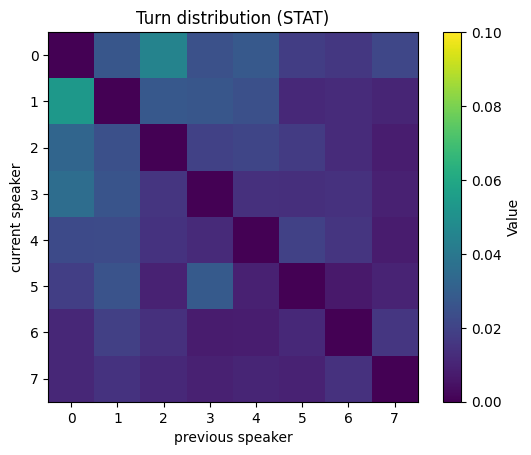

In [27]:
plt.imshow(model_array, cmap='viridis', vmin=0, vmax=0.1)
plt.colorbar(label='Value')  # Add a color bar to show the scale
plt.title('Turn distribution (STAT)')
plt.xlabel('previous speaker')
plt.ylabel('current speaker')
plt.show()

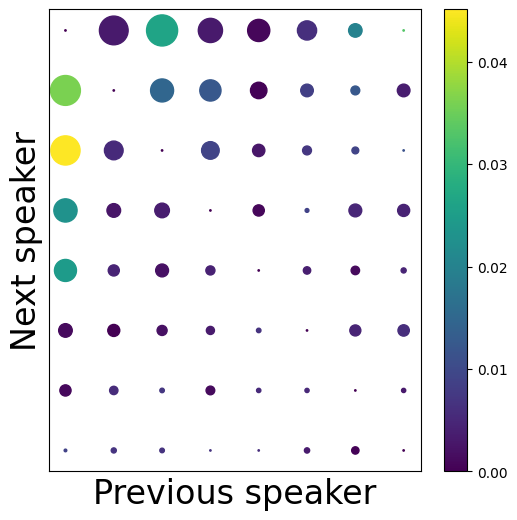

In [107]:
# Visualie the prediction results not normalized
size_matrix = result_array   # Size values

color_matrix = abs(result_array - model_array)        # Color values

# Create grid of positions
x, y = np.meshgrid(np.arange(8), np.arange(8))

# Flatten all for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()

sizes = size_matrix.flatten()
size_min, size_max = 1, 500
size_norm = (size_matrix - size_matrix.min()) / (size_matrix.max() - size_matrix.min())
sizes = size_norm * (size_max - size_min) + size_min

colors = color_matrix.flatten()

#vmin, vmax = 0.0, 2.0

# Plot
plt.figure(figsize=(6, 6))
scatter = plt.scatter(x_flat, y_flat, s=sizes, c=colors, cmap='viridis')
plt.gca().invert_yaxis()  # Invert y-axis if you want it to look like matrix layout
plt.colorbar(scatter)
plt.xticks(range(8))
plt.yticks(range(8))
plt.grid(True, linestyle='--', alpha=0.3)
#plt.title("Dot plot with size and color from two matrices")

plt.xticks([])
plt.yticks([])
plt.xlabel('Previous speaker', fontsize=24)
plt.ylabel('Next speaker', fontsize=24)
#plt.savefig("plots/MBC2_directtime_dot.pdf", format='pdf', bbox_inches="tight")
plt.show()

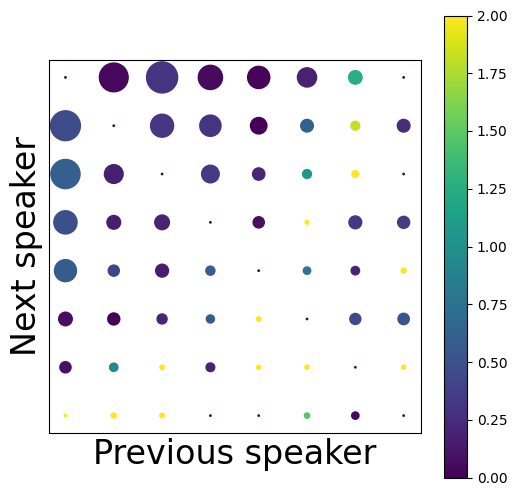

In [120]:
# Visualie the prediction results normalized
size_matrix = result_array   # Size values

color_matrix = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        if result_array[i,j] != 0:
            color_matrix[i,j] = abs(result_array[i,j] - model_array[i,j])/result_array[i,j]
#color_matrix = abs(result_array - model_array)        # Color values

# Create grid of positions
x, y = np.meshgrid(np.arange(8), np.arange(8))

# Flatten all for scatter plot
x_flat = x.flatten()
y_flat = y.flatten()

sizes = size_matrix.flatten()
size_min, size_max = 1, 500
size_norm = (size_matrix - size_matrix.min()) / (size_matrix.max() - size_matrix.min())
sizes = size_norm * (size_max - size_min) + size_min

colors = color_matrix.flatten()

vmin, vmax = 0.0, 2.0

# Plot
plt.figure(figsize=(6, 6))
scatter = plt.scatter(x_flat, y_flat, s=sizes, c=colors, cmap='viridis', vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()  # Invert y-axis if you want it to look like matrix layout
plt.colorbar(scatter)
plt.xticks(range(8))
plt.yticks(range(8))
plt.grid(True, linestyle='--', alpha=0.3)
#plt.title("Dot plot with size and color from two matrices")
plt.xticks([])
plt.yticks([])
plt.xlabel('Previous speaker', fontsize=24)
plt.ylabel('Next speaker', fontsize=24)
plt.gca().set_aspect('equal')
plt.savefig("plots/MBC3_directtime_dot_relative.pdf", format='pdf', bbox_inches="tight")
plt.show()

## Statistical Null Model

In [5]:
outputdir = "pairsoutput/MBC3/"

filename = "MBC2_turns_forattendboth23.pkl"
    
with open(outputdir + filename, 'rb') as file:
    MBC2_turns = pickle.load(file)

In [6]:
MBC2_turns

,First Name,Last Name,Name,Turns
0,Alex,Frañó,Alex Frañó,3
1,Anita,Disney,Anita Disney,10
2,Dan,Burnston,Dan Burnston,13
3,Debra,S. Karhson,Debra S. Karhson,9
4,Elizabeth,McNeill,Elizabeth McNeill,1
5,Howard,Gritton,Howard Gritton,6
6,Jessica,Bernard,Jessica Bernard,4
7,Jordan,Theriault,Jordan Theriault,10
8,Kate,Hong,Kate Hong,4
9,Lucas,Pinto,Lucas Pinto,6


In [82]:
# not used for now
# cf_list store the turn-switch distribution of statistical model
# cf_array is the average of turn-switch distribution over all session
num_samples = 10000
cf_list = []
cf_array = np.zeros((N,N))
for i in range(len(model_list)):
    turn_matrix = model_list[i]
    turn_distribution = turn_matrix.sum(axis=1)
    turn_distribution = turn_distribution / sum(turn_distribution)
    counterfactual = np.random.choice(range(1, 9), size=num_samples, p=turn_distribution)
    counterfactual_result = np.zeros((8, 8), dtype=int)
    # Loop through the array A
    for k in range(len(counterfactual) - 1):
        j = counterfactual[k] - 1  # Current element (adjust for 0-based indexing)
        i = counterfactual[k + 1] - 1  # Next element (adjust for 0-based indexing)
        if i != j:
            counterfactual_result[i, j] += 1

    row_sums = np.sum(counterfactual_result, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = counterfactual_result[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    #counterfactual_result = sorted_array/np.max(counterfactual_result)
    counterfactual_result = sorted_array/np.sum(counterfactual_result)
    
    cf_list.append(counterfactual_result[:N, :N])
    cf_array += counterfactual_result[:N, :N]
cf_array = cf_array/np.sum(cf_array)

In [59]:
num_samples = 10000
cf_list = []

for i in range(len(model_list)):

    turn_distribution = valid_speaker[i]['Turns'].astype('int').to_list()
    turn_distribution = np.array(turn_distribution) / sum(turn_distribution)
    counterfactual_result = np.zeros((len(turn_distribution), len(turn_distribution)))
    for row in range(len(turn_distribution)):
        for col in range(len(turn_distribution)):
            if row != col:
                counterfactual_result[row, col] = turn_distribution[row]*turn_distribution[col]
    counterfactual_result = counterfactual_result / counterfactual_result.sum()

    row_sums = np.sum(counterfactual_result, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = counterfactual_result[np.ix_(sorted_indices, sorted_indices)]
    
    cf_list.append(counterfactual_result)

In [53]:
turn_distribution

array([0.27272727, 0.15151515, 0.12121212, 0.09090909, 0.12121212,
       0.24242424])

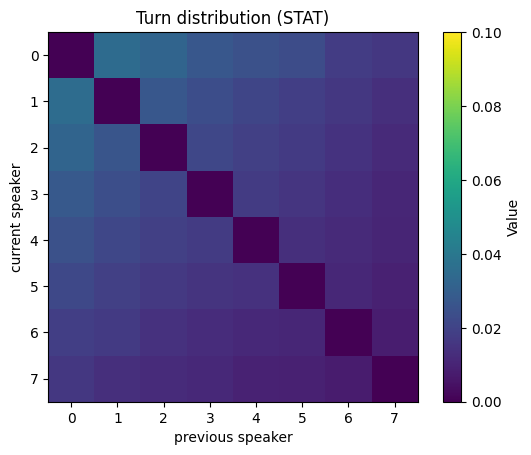

In [41]:
plt.imshow(cf_array, cmap='viridis', vmin=0, vmax=0.1)
plt.colorbar(label='Value')  # Add a color bar to show the scale
plt.title('Turn distribution (STAT)')
plt.xlabel('previous speaker')
plt.ylabel('current speaker')
plt.show()

## Random Null

In [ ]:
# randomly shuffle the id of people


In [80]:
dfs[0]

,start,end,speaker_id,confidence
24,418.89,424.76,3,0.89
25,430.23,444.88,3,0.89
26,449.96,452.91,3,0.89
27,455.61,473.34,3,0.89
28,476.80,486.00,3,0.89
...,...,...,...,...
353,4436.31,4440.65,1,0.89
354,4446.65,4448.80,8,0.78
355,4448.14,4452.11,3,0.89
356,4464.68,4468.41,5,0.22


In [83]:
trail = 100
N = 8
random_trail_list = []

for i in range(trail):

    random_time_list = []

    random_transition_matrix_time = pd.DataFrame(0, index=states, columns=states, dtype=float)

    first_column = 'speaker_id'
    second_column = 'prev_speaker_id'

    for i in range(len(dfs)):
        tmp_df = dfs[i]
        # Get unique IDs from the third column
        unique_ids = tmp_df.iloc[:, 2].unique()
        # Randomly assign new IDs
        tmp_df.iloc[:, 2] = np.random.choice(unique_ids, size=len(tmp_df))

        transition_df = turn_switch(tmp_df)
        name_dict = name_dicts[i]

        tmp_states = name_dfs[i]['Name'].unique()
        tmp_transition_matrix_turn = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)
        tmp_transition_matrix_time = pd.DataFrame(0, index=tmp_states, columns=tmp_states, dtype=float)

        for j in range(len(transition_df)):
            current_state = transition_df[first_column].iloc[j] #'order'
            next_state = transition_df[second_column].iloc[j] #'order'
            if current_state in name_dict and next_state in name_dict:
                current_state = name_dict[current_state] #convert to 'name'
                next_state = name_dict[next_state] #convert to 'name'

                tmp_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['end'] - transition_df.iloc[j]['start']
                random_transition_matrix_time.loc[current_state, next_state] += transition_df.iloc[j]['end'] - transition_df.iloc[j]['start']

        random_time_list.append(tmp_transition_matrix_time)


    random_array = np.zeros((N,N))
    random_list = []
    for i in range(len(random_time_list)):
        tmp = random_time_list[i].to_numpy()
        row_sums = np.sum(tmp, axis=1)
        sorted_indices = np.argsort(row_sums)[::-1]
        sorted_array = tmp[np.ix_(sorted_indices, sorted_indices)]
        random_list.append(sorted_array[:N, :N]/np.sum(sorted_array[:N, :N]))
        random_array += sorted_array[:N, :N]
    random_array = random_array/len(random_time_list)
    random_array = random_array/np.sum(random_array)
    
    random_trail_list.append(random_array)
    

In [89]:
random_rmse_error = random_trail_list - result_array
random_norms = np.linalg.norm(random_rmse_error, axis=(-2, -1))

norms_lower_bound = np.percentile(random_norms, 2.5)
norms_upper_bound = np.percentile(random_norms, 97.5)
norms_mean_bound = np.mean(random_norms)

print(norms_lower_bound, norms_mean_bound, norms_upper_bound)
print(norms_lower_bound - norms_mean_bound, norms_mean_bound - norms_upper_bound)

0.12246484543228621 0.13238802121642657 0.14654728455689928
-0.009923175784140356 -0.01415926334047271


In [91]:
random_trail_list[0]

array([[0.        , 0.05342221, 0.03137664, 0.02006992, 0.04035758,
        0.03183127, 0.02192114, 0.02190997],
       [0.0448951 , 0.        , 0.01398266, 0.02782335, 0.02905803,
        0.01128758, 0.01332464, 0.0204089 ],
       [0.01869566, 0.02457155, 0.        , 0.02354345, 0.02527822,
        0.02360008, 0.02079334, 0.00876239],
       [0.01198947, 0.02195863, 0.02628638, 0.        , 0.01717863,
        0.01561773, 0.01826336, 0.0199431 ],
       [0.00983277, 0.02030999, 0.01858719, 0.01477228, 0.        ,
        0.02477893, 0.01836466, 0.00812591],
       [0.01073006, 0.01009996, 0.00722383, 0.01931459, 0.01993831,
        0.        , 0.01138489, 0.00942839],
       [0.01152208, 0.01397867, 0.00964294, 0.00904474, 0.01047723,
        0.00593651, 0.        , 0.01606997],
       [0.0104852 , 0.01491824, 0.00731476, 0.00597001, 0.00745673,
        0.01328556, 0.0028546 , 0.        ]])

In [92]:
random_corr = np.zeros((100,))
for i in range(100):
    tmp_corr = np.corrcoef(result_array.flatten(), random_trail_list[i].flatten())
    random_corr[i] = tmp_corr[0,1]

norms_lower_bound = np.percentile(random_corr, 2.5)
norms_upper_bound = np.percentile(random_corr, 97.5)
norms_mean_bound = np.mean(random_corr)

print(norms_lower_bound, norms_mean_bound, norms_upper_bound)
print(norms_lower_bound - norms_mean_bound, norms_mean_bound - norms_upper_bound)

0.48615811337023535 0.6292981327954971 0.7195935893518115
-0.14314001942526172 -0.09029545655631444


## Compare to real data

In [110]:
# cf_list_real store the turn-switch distribution of statistical model
# cf_array_real is the average of turn-switch distribution over all session
num_samples = 100000
cf_array_real = np.zeros((N,N))

turn_matrix = result_array
turn_distribution = turn_matrix.sum(axis=1)
turn_distribution = turn_distribution / sum(turn_distribution)
counterfactual = np.random.choice(range(1, len(data_list[i])+1), size=num_samples, p=turn_distribution)
counterfactual_result = np.zeros((len(data_list[i]), len(data_list[i])), dtype=int)
# Loop through the array A
for k in range(len(counterfactual) - 1):
    j = counterfactual[k] - 1  # Current element (adjust for 0-based indexing)
    i = counterfactual[k + 1] - 1  # Next element (adjust for 0-based indexing)
    if i != j:
        counterfactual_result[i, j] += 1

row_sums = np.sum(counterfactual_result, axis=1)
sorted_indices = np.argsort(row_sums)[::-1]
sorted_array = counterfactual_result[np.ix_(sorted_indices, sorted_indices)]
#sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
#counterfactual_result = sorted_array/np.max(counterfactual_result)
counterfactual_result = sorted_array/np.sum(counterfactual_result)

In [143]:
counterfactual_result

array([[0.        , 0.05700355, 0.04765831, 0.04153969, 0.03151328,
        0.02336309, 0.01873827, 0.0097874 ],
       [0.05530659, 0.        , 0.03445309, 0.02997168, 0.02226365,
        0.01606138, 0.01343228, 0.0068954 ],
       [0.04773002, 0.03321024, 0.        , 0.02479714, 0.01884583,
        0.0138864 , 0.01082709, 0.00614252],
       [0.0416831 , 0.0291949 , 0.02473739, 0.        , 0.01610918,
        0.0124643 , 0.01007421, 0.00516259],
       [0.03197935, 0.02159443, 0.0179854 , 0.01596577, 0.        ,
        0.00902257, 0.00764827, 0.00388389],
       [0.02307628, 0.01686206, 0.01371909, 0.01259575, 0.00856846,
        0.        , 0.0054494 , 0.00307126],
       [0.01926409, 0.01339643, 0.01124535, 0.00930938, 0.00678784,
        0.0054733 , 0.        , 0.002653  ],
       [0.01056418, 0.00712246, 0.00562865, 0.00524624, 0.00399144,
        0.00308321, 0.00195987, 0.        ]])

In [101]:
i=1
tmp_data = data_list[i]
tmp_cf = cf_list_real[i]
print(np.linalg.norm(abs(tmp_data - tmp_cf)))

0.11427518628192875


In [144]:
i=5
tmp_data = data_list[i][:N,:N]/data_list[i][:N,:N].sum()
print(np.linalg.norm(abs(tmp_data - counterfactual_result)))


0.2541474921061994


In [ ]:
## model_diff = 0
cf_diff = 0
for i in range(8):
    print(i)
    tmp_data = data_list[i]
    tmp_model = model_list[i]
    tmp_cf = cf_list[i]
    model_diff += np.linalg.norm(abs(tmp_data - tmp_model))
    cf_diff += np.linalg.norm(abs(tmp_data - tmp_cf))
model_diff = model_diff / 8
cf_diff = cf_diff / 8
    

In [69]:
model_diff

0.4188563457012528

In [70]:
cf_diff

0.4016853332602006

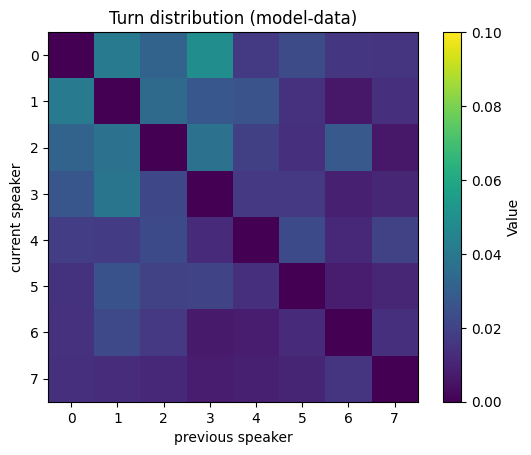

In [43]:
plt.imshow(model_diff, cmap='viridis', vmin=0, vmax=0.1)
plt.colorbar(label='Value')  # Add a color bar to show the scale
plt.title('Turn distribution (model-data)')
plt.xlabel('previous speaker')
plt.ylabel('current speaker')
plt.show()

In [45]:
np.linalg.norm(model_diff)

0.16282397596464085

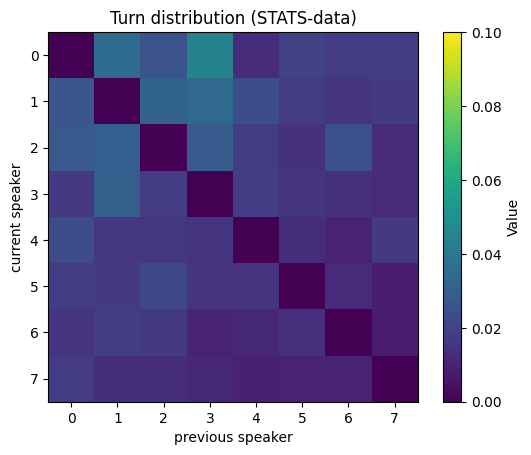

In [47]:
plt.imshow(cf_diff, cmap='viridis', vmin=0, vmax=0.1)
plt.colorbar(label='Value')  # Add a color bar to show the scale
plt.title('Turn distribution (STATS-data)')
plt.xlabel('previous speaker')
plt.ylabel('current speaker')
plt.show()

In [48]:
np.linalg.norm(cf_diff)

0.14653008987619953

In [98]:
# cf_list_real store the turn-switch distribution of statistical model
# cf_array_real is the average of turn-switch distribution over all session
num_samples = 10000
cf_list_real = []
cf_array_real = np.zeros((N,N))
for i in range(len(data_list)):
    turn_matrix = data_list[i]
    turn_distribution = turn_matrix.sum(axis=1)
    turn_distribution = turn_distribution / sum(turn_distribution)
    counterfactual = np.random.choice(range(1, len(data_list[i])+1), size=num_samples, p=turn_distribution)
    counterfactual_result = np.zeros((len(data_list[i]), len(data_list[i])), dtype=int)
    # Loop through the array A
    for k in range(len(counterfactual) - 1):
        j = counterfactual[k] - 1  # Current element (adjust for 0-based indexing)
        i = counterfactual[k + 1] - 1  # Next element (adjust for 0-based indexing)
        if i != j:
            counterfactual_result[i, j] += 1

    row_sums = np.sum(counterfactual_result, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = counterfactual_result[np.ix_(sorted_indices, sorted_indices)]
    #sorted_array = np.sort(sorted_array, axis=1)[:, ::-1]
    #counterfactual_result = sorted_array/np.max(counterfactual_result)
    counterfactual_result = sorted_array/np.sum(counterfactual_result)
    
    #cf_list_real.append(counterfactual_result[:N, :N])
    cf_list_real.append(counterfactual_result)
    cf_array_real += counterfactual_result[:N, :N]
cf_array_real = cf_array/np.sum(cf_array_real)

In [50]:
cf_real_diff = np.zeros((N,N))
for i in range(len(data_list)):
    tmp_data = data_list[i]
    tmp_cf_real = cf_list_real[i]
    cf_real_diff += abs(tmp_data - tmp_cf_real)
cf_real_diff = cf_real_diff / len(data_list)

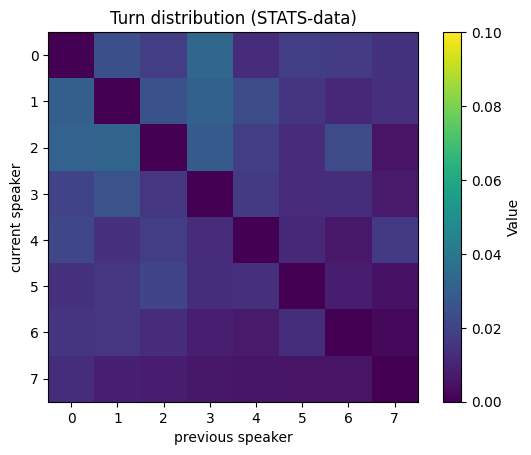

In [51]:
plt.imshow(cf_real_diff, cmap='viridis', vmin=0, vmax=0.1)
plt.colorbar(label='Value')  # Add a color bar to show the scale
plt.title('Turn distribution (STATS-data)')
plt.xlabel('previous speaker')
plt.ylabel('current speaker')
plt.show()

In [52]:
np.linalg.norm(cf_real_diff)

0.129512721983856

Is the transition really random?

In [141]:
# cf_list_real store the turn-switch distribution of statistical model
# cf_array_real is the average of turn-switch distribution over all session
trail = 100
i = 0
num_samples = trans_matrix_turn_list[i].to_numpy().sum()

turn_matrix = data_list[i]
turn_distribution = turn_matrix.sum(axis=1)
turn_distribution = turn_distribution / sum(turn_distribution)
for i in range(trail):
    counterfactual = np.random.choice(range(1, len(data_list[i])+1), size=num_samples, p=turn_distribution)
    counterfactual_result = np.zeros((len(data_list[i]), len(data_list[i])), dtype=int)
    # Loop through the array A
    for k in range(len(counterfactual) - 1):
        j = counterfactual[k] - 1  # Current element (adjust for 0-based indexing)
        i = counterfactual[k + 1] - 1  # Next element (adjust for 0-based indexing)
        if i != j:
            counterfactual_result[i, j] += 1

    row_sums = np.sum(counterfactual_result, axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    sorted_array = counterfactual_result[np.ix_(sorted_indices, sorted_indices)]

    

129.0

In [145]:
trans_matrix_turn_list[0].to_numpy().sum()

129.0